<a href="https://colab.research.google.com/github/seansothey/CSC685/blob/master/Project6_Unsupervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://cdn.educba.com/academy/wp-content/uploads/2019/10/Unsupervised-Machine-Learning.jpg)

Unsupervised learning is a type of machine learning algorithm used to draw inferences from datasets consisting of input data without labeled responses. The most common unsupervised learning method is cluster analysis, which is used for exploratory data analysis to find hidden patterns or grouping in data. Within this experiment, the datasets (image type) and machine learning techniques are described below.

**Image Datasets:**


*   Bridge: 4x4 pixel blocks of bridge images, contained 4096 pixel blocks.   
http://cs.joensuu.fi/sipu/datasets/ 
*   Coil-100: The dataset contains 7200 color images of 100 objects (72 images per object)  
https://www.cs.columbia.edu/CAVE/software/softlib/coil-100.php

*   Celeb: CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter. CelebA has large diversities, large quantities, and rich annotations, including, 10,177 number of identities, 202,599 number of face images, and 5 landmark locations, 40 binary attributes annotations per image.   
http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
*   ImageNet: Images are collected variously from internet, come with two resolutions, 32x32 and 64x64.   
http://image-net.org/small/download.php


**Machine Learning Techniques:** 


*   K-Means Clustering
*   RandomForest Classifier
*   GuassianMixture Classifier
*   Anomaly Detection Using GuassianMixture







#Setup

In [128]:
# Common Import
import sklearn
import pandas as pd
import numpy as np
from sklearn import metrics
import seaborn as sns
import os
import time
import random

import tarfile
import cv2
from google.colab.patches import cv2_imshow

# to make this notebook's output stable across runs
np.random.seed(42)

from zipfile import ZipFile


from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler,LabelEncoder

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore")

# sklearn version > 0.20 is required 
sklearn.__version__
# Update sklearn -> !pip install -U scikit-learn

'0.22.2.post1'

#Custom Functions

This is a fucntion to download a file using **URL**. Then save it in the **save_path** with **target_file_name**. If target_file_name is empty, then the file name will be gotten from the URL.

In [0]:
import urllib
import urllib.parse as parse

def download(url,save_path,target_file_name=''):
  print("file is being downloading from {} ...".format(url))
  file = urllib.request.urlopen(url)
  fileData = file.read()

  if target_file_name=='':
    split=parse.urlsplit(url)
    target_file_name = split.path.split('/')[-1]
  
  if not os.path.exists(save_path):
    os.mkdir(save_path)

  targetFile = os.path.join(save_path,target_file_name)
  with open(targetFile,'wb') as f:
    f.write(fileData)
  print('Done, file in the path {}'.format(targetFile))

This is a function to extract tar file in the **tar_file_path**, which includes the file name and the extension, to **target_path**.

In [0]:
def extractTar(tar_file_path,target_path):
    print("Extracting is starting....")
    tar=tarfile.open(tar_file_path)
    tar.extractall(target_path)
    tar.close()
    print("Done")

This is a function to extract zip file in the **zip_file_path**, which includes the file name and the extension, to **target_path**.

In [0]:
def extractZip(zip_file_path,target_path):
    print("Extracting is starting....")
    zFile=ZipFile(zip_file_path)
    zFile.extractall(target_path)
    zFile.close()
    print("Done")

This is a custom function to create a imgs set without labels, unsupervised dataset. It used the folder path of the imgs.

In [0]:
def create_img_set(imgs_folder_path):
  x=[]
  lst = os.listdir(imgs_folder_path)
  for img in lst:
    img_imr = cv2.imread(os.path.join(imgs_folder_path,img))
    img_imr = cv2.resize(img_imr,(32,32))
    x.append(np.array(img_imr))
  return x

randomly_sho_imgs is for randomly display nrows x ncols images from the training set 

In [0]:
def randomly_show_imgs(x_set,nrows,ncols):
  plt.figure(figsize=(10,10))
  for i in range(nrows*ncols):
    plt.subplot(nrows,ncols,i+1)
    indx = random.randint(0,len(x_set))
    plt.imshow(x_set[indx])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
  plt.show()

plot_data is to generate a plot chart from the x data

In [0]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

plot_centroids to generate a plot chart with the centers point passed

In [0]:
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

plot_decision_boundaries is to generate a Voronoi diagram:

In [0]:
def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

plot_gaussian_mixture is to generate a plot chart for gaussian_mixture

In [0]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

create the following directeries to save the **downsampled and celeba datasets**

In [0]:
root_path = 'data'
if not os.path.exists(root_path):
  os.mkdir(root_path)

downsampled_path = os.path.join(root_path,'downsampled')
if not os.path.exists(downsampled_path):
  os.mkdir(downsampled_path)

celeba_path = os.path.join(root_path,'celeba')
if not os.path.exists(celeba_path):
  os.mkdir(celeba_path)

# Clustering Bridge Image Dataset

##Data Scrubing

## Loading Data

In [0]:
bridge = pd.read_csv('https://raw.githubusercontent.com/seansothey/CSC685/master/bridge.txt', delim_whitespace=True, header=None) #avoid spaces separated

In [140]:
bridge.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,6,8,6,9,0,0,0,0,0,0,0,0,0,0,0,0
1,7,4,3,4,0,0,0,0,0,0,0,0,0,0,0,0
2,8,8,8,18,31,12,22,34,74,74,68,60,96,99,104,79
3,9,9,16,34,11,15,38,54,60,22,65,75,99,78,92,114
4,9,19,34,39,23,26,31,39,16,31,34,41,59,63,33,38


In [141]:
bridge.shape

(4096, 16)

In [142]:
bridge.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
dtype: int64

In [0]:
bridge_np = np.array(bridge) #convert dataframe to numpy array

In [144]:
bridge_np

array([[  6,   8,   6, ...,   0,   0,   0],
       [  7,   4,   3, ...,   0,   0,   0],
       [  8,   8,   8, ...,  99, 104,  79],
       ...,
       [251, 247, 243, ..., 127, 141, 153],
       [252, 250, 249, ...,  92,  94,  99],
       [253, 224, 209, ..., 246, 233, 227]])

In [0]:
bridge4x4 = bridge_np.reshape(4096,4,4)

### Data Visualization

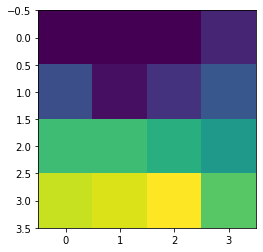

In [146]:
plt.imshow(bridge4x4[2]) #view the image index=2

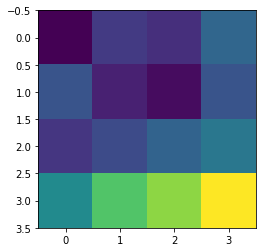

In [147]:
plt.imshow(bridge4x4[10]) #view the image index=10

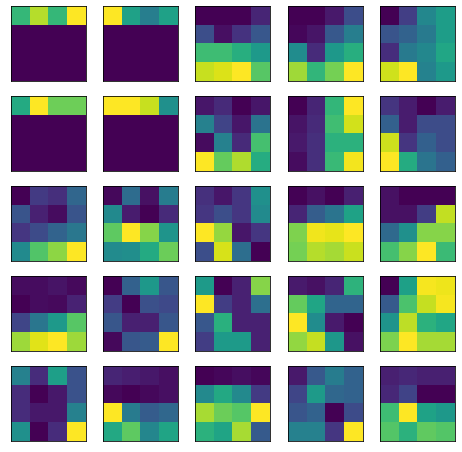

In [148]:
# See 25 images
plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(bridge4x4[i])

Text(0.5, 1.0, 'Bridge Dataset')

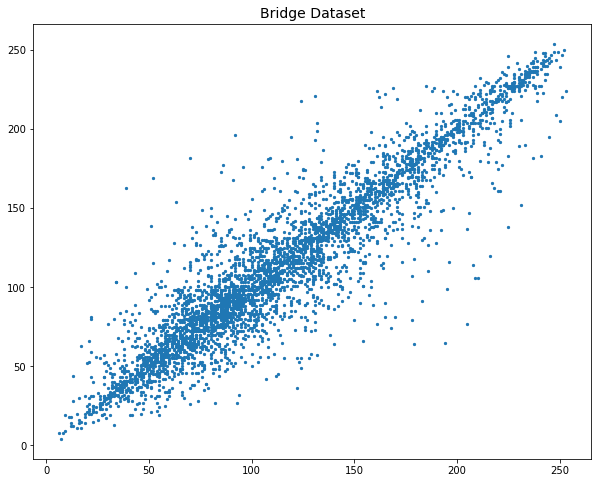

In [149]:
# See the whole dataset in 2d axis 
plt.figure(figsize=(10,8))
plt.scatter(bridge_np[:,0], bridge_np[:,1], s=5)
plt.title("Bridge Dataset", fontsize=14)

### Apply PCA (Variation = 99%)

In [150]:
pca = PCA(0.99)
X_bridge_pca = pca.fit_transform(bridge_np)
pca.n_components_

12

##K-means clustering

Choose random numbers of $k$ to find the best one

In [151]:
k_range = range(2,10,2)
kmeans_per_k = []
for k in k_range:
    print("k={}".format(k))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_bridge_pca)
    kmeans_per_k.append(kmeans)

k=2
k=4
k=6
k=8


### Plot the silhouette score vs performance of $k$

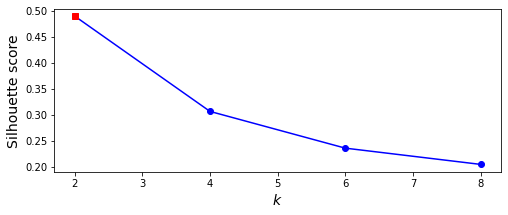

In [152]:
silhouette_scores = [silhouette_score(X_bridge_pca, model.labels_) for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, "rs")
plt.show()

###$k$=2 return the highest Sihouette score

In [153]:
best_k

2

##Plot K-Elbow

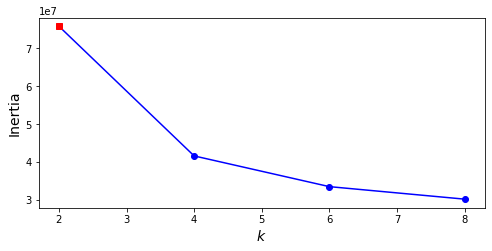

In [154]:
inertias = [model.inertia_ for model in kmeans_per_k]
best_inertia = inertias[best_index]

plt.figure(figsize=(8, 3.5))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.plot(best_k, best_inertia, "rs")
plt.show()

The elbow point is k=2

### Fit and Predict

In [0]:
kmodel = KMeans(n_clusters=2, random_state=42)

In [0]:
y = kmodel.fit_predict(X_bridge_pca)

In [157]:
np.unique(y)

array([0, 1], dtype=int32)

In [158]:
len(y)

4096

In [159]:
y is kmodel.labels_

True

Therefore, y (0,1) is the label that represents for each cluster.

##With RandomForest Classifier

## Spliting data for training and testing set in ratio 70%-30%

In [0]:
X_bridge_train, X_bridge_test, y_bridge_train, y_bridge_test = train_test_split(X_bridge_pca, y, test_size=0.3, shuffle = True, random_state=42)

In [161]:
X_bridge_train.shape, X_bridge_test.shape, y_bridge_train.shape, y_bridge_test.shape

((2867, 12), (1229, 12), (2867,), (1229,))

Create the model and fit with the training set

In [162]:
from sklearn.ensemble import RandomForestClassifier

RF_bridge = RandomForestClassifier(random_state=42)
RF_bridge.fit(X_bridge_train, y_bridge_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Perform cross validation using subset size 500

In [163]:
cross_val_score(RF_bridge, X_bridge_train[:500], y_bridge_train[:500], cv=3, scoring='accuracy').mean()

0.995995959887454

Test the model using testing set

In [164]:
RF_bridge.score(X_bridge_test, y_bridge_test)

1.0

See the predict score

In [165]:
y_pred = RF_bridge.predict(X_bridge_pca)
y_pred

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [166]:
accuracy_score(y, y_pred)

1.0

See the confustion matrix

In [167]:
labels= np.unique(kmodel.labels_)
labels

array([0, 1], dtype=int32)

Text(0.5, 1.0, 'Confusion Matrix')

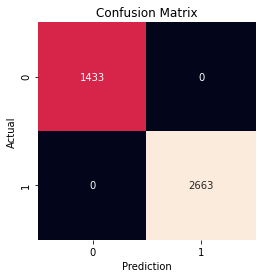

In [168]:
mat = confusion_matrix(y_pred, y)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Prediction')
plt.ylabel('Actual');
plt.title('Confusion Matrix')

See how RF classify the first 25 images

AttributeError: ignored

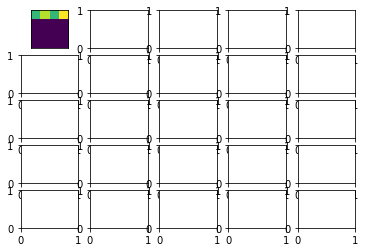

In [169]:
fig, ax = plt.subplots(5, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(bridge4x4[i])
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(labels[y_pred[i]].split()[-1],
                   color='black' if y_pred[i] == y[i] else 'red')
fig.suptitle('Incorrect prediction shown in red', size=14);

There's no red number popup, that mean 100% rate prediction as expected.

##Use K-Means as a dimensionality reduction tool and train a classifier on the reduced set

In [0]:
best_model = kmeans_per_k[best_index]
X_train_reduced = best_model.transform(X_bridge_train)
X_test_reduced = best_model.transform(X_bridge_test)

Perform cross validation using subset size 500

In [171]:
cross_val_score(RF_bridge, X_train_reduced[:500], y_bridge_train[:500], cv=3, scoring='accuracy').mean()

0.9900079359353583

Fit to training model

In [172]:
RF_bridge.fit(X_train_reduced, y_bridge_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Test the model using testing set

In [173]:
RF_bridge.score(X_test_reduced, y_bridge_test)

0.9975589910496339

The classifier performance is very similar to PCA.

## Search for the number of clusters that provides the best performance.

In [174]:
from sklearn.pipeline import Pipeline

pipe_bridge_scores = []
for n_clusters in range(1,11):
    pipe_bridge = Pipeline([
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=42)),
        ("forest_clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    pipe_bridge.fit(X_bridge_train, y_bridge_train)

    pipe_bridge_scores.append([])
    pipe_bridge_scores[n_clusters-1].append(n_clusters)
    score = pipe_bridge.score(X_bridge_test, y_bridge_test)
    pipe_bridge_scores[n_clusters-1].append(score)


    print(n_clusters, score)

1 0.6143205858421481
2 0.9983726606997559
3 0.9951179820992677
4 0.9975589910496339
5 0.9983726606997559
6 0.9983726606997559
7 0.9975589910496339
8 0.9983726606997559
9 0.9983726606997559
10 0.9975589910496339


### n_clusters >= 2 provides classifier similart highest performance.

##With Gaussian Mixtures

Apply PCA (99% variataion)

Train the GaussianMixture model on the training set with PCA(99% variation)

In [175]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=2, n_init=10, random_state=42)
gm.fit(X_bridge_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

Did the algorithm actually converge?

In [176]:
gm.converged_

True

How many iterations did it take?

In [177]:
gm.n_iter_

20

You can now use the model to predict which cluster each instance belongs to (hard clustering).

In [178]:
gm.predict(X_bridge_test)

array([0, 0, 0, ..., 0, 1, 1])

Now let's plot the resulting decision boundaries (dashed lines) and density contours:

In [0]:
plt.figure(figsize=(8, 6))
plot_gaussian_mixture(gm, X_bridge_pca)
plt.show()

## Anomaly Detection using Gaussian Mixtures

In [0]:
densities = gm.score_samples(X_bridge_pca)
density_threshold = np.percentile(densities, 5) #Choose 5% for threshold
anomalies = X_bridge_pca[densities < density_threshold]

In [0]:
plt.figure(figsize=(10, 8))
plot_gaussian_mixture(gm, X_bridge_pca)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)
plt.show()

# Clustering Coil-100 Image Dataset

##Data Scrubing

## Loading Data

Download Coil100 from Sean Kaggle

In [0]:
root_path = 'data'
if not os.path.exists(root_path):
  os.mkdir(root_path)

In [181]:
download('https://storage.googleapis.com/kaggle-data-sets/589973/1063434/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1586506868&Signature=OeomkNazrVOV6QMP6sd%2BMUJITjJSg0lk5tIpWhJOwU4c4VCK7E3PxxEKlovk4x8XBGKmtL90cQUy5BoQSo%2BdulwmSx41RqZYkRHPMyvhgydFX0wAol%2Fy75828DdowN37isM04sYFTD4PleKuj7hD95bFWvv1mKSh0w%2BIZAEaMsS6bOvqPpXkJYN1G8mffLUFWpKGklEX6Y4ERiMGhIlQBp9RH1WHAYSyoreld0g02%2FkrVzub8i%2B9D1sOPfG%2F8VfXgxyVoACA2lSRJycZ7me2wuAmBLx%2FlhivpHI2dLZ%2BBymxtmxhvDnDioxDl7wwQqYqy9MMUAlXPZPvlMJ%2Baf%2FaLQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dcoil100.zip',os.path.join(root_path,'coil100'),'coil100.zip')

file is being downloading from https://storage.googleapis.com/kaggle-data-sets/589973/1063434/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1586506868&Signature=OeomkNazrVOV6QMP6sd%2BMUJITjJSg0lk5tIpWhJOwU4c4VCK7E3PxxEKlovk4x8XBGKmtL90cQUy5BoQSo%2BdulwmSx41RqZYkRHPMyvhgydFX0wAol%2Fy75828DdowN37isM04sYFTD4PleKuj7hD95bFWvv1mKSh0w%2BIZAEaMsS6bOvqPpXkJYN1G8mffLUFWpKGklEX6Y4ERiMGhIlQBp9RH1WHAYSyoreld0g02%2FkrVzub8i%2B9D1sOPfG%2F8VfXgxyVoACA2lSRJycZ7me2wuAmBLx%2FlhivpHI2dLZ%2BBymxtmxhvDnDioxDl7wwQqYqy9MMUAlXPZPvlMJ%2Baf%2FaLQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dcoil100.zip ...
Done, file in the path data/coil100/coil100.zip


In [182]:
extractZip('data/coil100/coil100.zip', 'data/coil100/imgs')

Extracting is starting....
Done


In [0]:
coil_100_lst = os.listdir('data/coil100/imgs/coil-100')

In [184]:
len(coil_100_lst)

7202

before deleteing none-image files the number of files are 7202 

In [185]:
# Remove files that are not image
for item in coil_100_lst:
    if not item.lower().endswith('.png'):
      path = os.path.join('data/coil100/imgs/coil-100', item)
      os.remove(path)
      print('Successfully deleted the file: {}'.format(path))

Successfully deleted the file: data/coil100/imgs/coil-100/convertGroupppm2png.pl~
Successfully deleted the file: data/coil100/imgs/coil-100/convertGroupppm2png.pl


after deleting the non-image files with total 2 files.

In [186]:
coil_100_lst = os.listdir('data/coil100/imgs/coil-100')
len(coil_100_lst)

7200

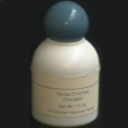

image size (128, 128, 3) 


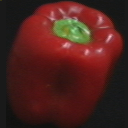

image size (128, 128, 3) 


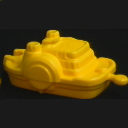

image size (128, 128, 3) 


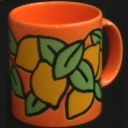

image size (128, 128, 3) 


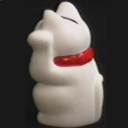

image size (128, 128, 3) 


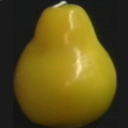

image size (128, 128, 3) 


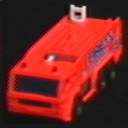

image size (128, 128, 3) 


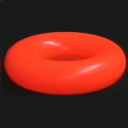

image size (128, 128, 3) 


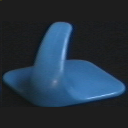

image size (128, 128, 3) 


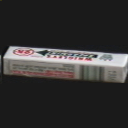

image size (128, 128, 3) 


In [187]:
# Plot to see some images of the dataset
for i in range(10):
  rndIndx = random.randint(0,len(coil_100_lst)-1)
  img = cv2.imread(os.path.join('data/coil100/imgs/coil-100',coil_100_lst[rndIndx]))
  cv2_imshow(img)
  print('image size {} '.format(img.shape))


###Create the images dataset

In [0]:
coil_100=create_img_set(os.path.join('data/coil100/imgs/coil-100'))

Show randomly 25 images from the training set

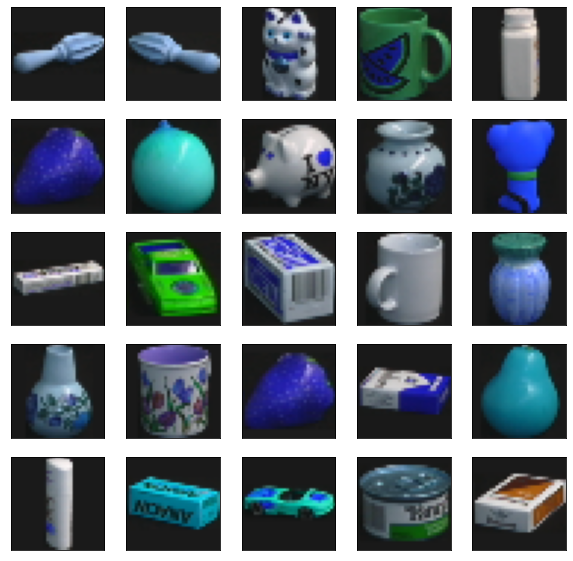

In [189]:
randomly_show_imgs(coil_100,5,5)

###Flatten the set

convert first the coil_100 from list to numpy array

In [0]:
coil_100_npa = np.array(coil_100)

In [191]:
coil_100_npa.shape

(7200, 32, 32, 3)

Convert to 2D dimension

In [0]:
nsamples, nx, ny, nz = coil_100_npa.shape
coil_100_npa = coil_100_npa.reshape((nsamples,nx*ny*nz))

In [193]:
coil_100_npa.shape

(7200, 3072)

###Plot the dataset

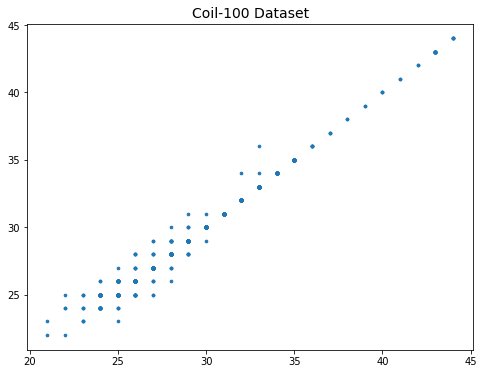

In [194]:
plt.figure(figsize=(8,6))
plt.scatter(coil_100_npa[:,0],coil_100_npa[:,1],s=7)
plt.title('Coil-100 Dataset',fontsize =14)
plt.show()

### Apply PCA (Variation = 99%)

In [195]:
pca = PCA(0.99)
X_coil100_pca = pca.fit_transform(coil_100_npa)
pca.n_components_

755

##K-means clustering

Choose random numbers of $k$ to find the best one

In [196]:
k_range = range(50,300,50)
kmeans_per_k = []
for k in k_range:
    print("k={}".format(k))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_coil100_pca)
    kmeans_per_k.append(kmeans)

k=50
k=100
k=150
k=200
k=250


### Plot the silhouette score vs performance of $k$

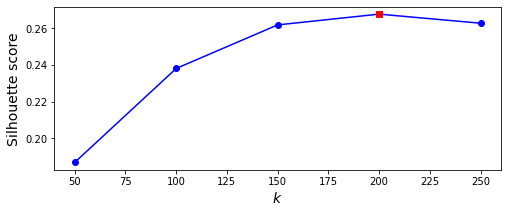

In [197]:
silhouette_scores = [silhouette_score(X_coil100_pca, model.labels_) for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, "rs")
plt.show()

###$k$=200 return the highest Sihouette score

In [198]:
best_k

200

##Plot K-Elbow

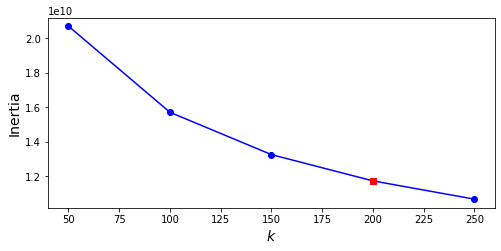

In [199]:
inertias = [model.inertia_ for model in kmeans_per_k]
best_inertia = inertias[best_index]

plt.figure(figsize=(8, 3.5))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.plot(best_k, best_inertia, "rs")
plt.show()

The elbow point is k=200

### Fit and Predict

Let's train a K-Means clusterer on this dataset. It will try to find each blob's center and assign each instance to the closest blob:

In [0]:
kmodel = KMeans(n_clusters=best_k, random_state=42)

In [0]:
y_coil100 = kmodel.fit_predict(X_coil100_pca)

In [202]:
y_coil100

array([115, 131, 106, ..., 111,  46, 163], dtype=int32)

In [203]:
np.unique(y_coil100)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [204]:
y_coil100 is kmodel.labels_

True

Therefore, y is the label (0, 1,..,199) tha represents for each cluster.

##With RandomForest Classifier

## Spliting data for training and testing set in ratio 70%-30%

In [0]:
X_coil100_train, X_coil100_test, y_coil100_train, y_coil100_test = train_test_split(X_coil100_pca, y_coil100, test_size=0.3, shuffle = True, random_state=42)

In [206]:
X_coil100_train.shape, X_coil100_test.shape, y_coil100_train.shape, y_coil100_test.shape

((5040, 755), (2160, 755), (5040,), (2160,))

Create the model and fit with the training set

In [207]:
from sklearn.ensemble import RandomForestClassifier

RF_coil100 = RandomForestClassifier(random_state=42)
RF_coil100.fit(X_coil100_train, y_coil100_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Perform cross validation using subset size 500

In [208]:
cross_val_score(RF_coil100, X_coil100_pca[:500], y_coil100[:500], cv=3, scoring='accuracy').mean()

0.4840439602722266

Test the model using testing set

In [209]:
RF_coil100.score(X_coil100_test, y_coil100_test)

0.9314814814814815

See the predict score

In [210]:
y_pred = RF_coil100.predict(X_coil100_pca)
y_pred

array([115, 131, 106, ..., 111,  46, 163], dtype=int32)

In [212]:
accuracy_score(y_coil100, y_pred)

0.9794444444444445

See the confustion matrix

In [0]:
labels= np.unique(kmodel.labels_)

With 200 labels, the table would be too nasty to read.

Text(0.5, 1.0, 'Confusion Matrix')

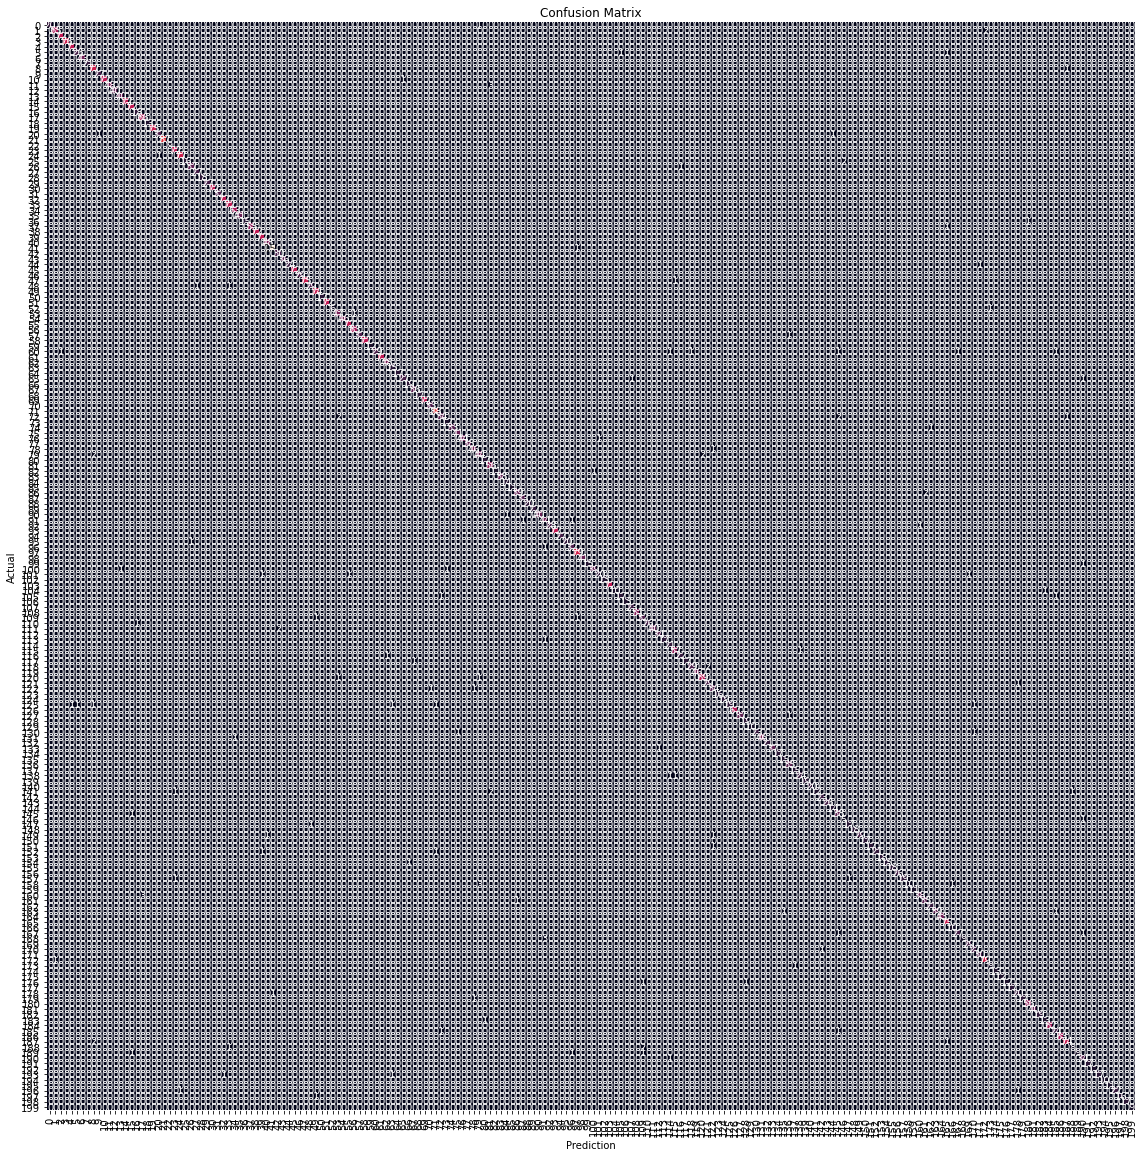

In [215]:
fig, ax = plt.subplots(figsize=(10,10)) 
mat = confusion_matrix(y_pred, y_coil100)
sns.heatmap(mat.T, square=True, annot=True,fmt='d',
            cbar=False, ax=ax,
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Prediction')
plt.ylabel('Actual');
plt.title('Confusion Matrix')

See how RF classify the first 25 images

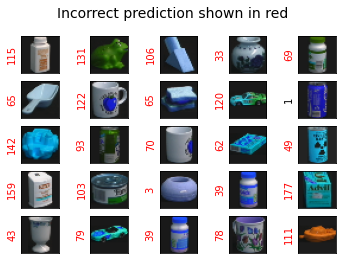

In [216]:
fig, ax = plt.subplots(5, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(coil_100[i])
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(str(labels[y_pred[i]]).split()[-1],
                   color='black' if y_pred[i] == y[i] else 'red')
fig.suptitle('Incorrect prediction shown in red', size=14);

No red was spot, that mean only no error prediction in the first 25 images.

##Use K-Means as a dimensionality reduction tool and train a classifier on the reduced set

In [0]:
best_model = kmeans_per_k[best_index]
X_train_coil100_reduced = best_model.transform(X_coil100_train)
X_test_coil100_reduced = best_model.transform(X_coil100_test)

Perform cross validation using subset size 500

In [218]:
cross_val_score(RF_bridge, X_train_coil100_reduced[:500], y_coil100_train[:500], cv=3, scoring='accuracy').mean()

0.739977875574153

Fit to training model

In [219]:
RF_coil100.fit(X_train_coil100_reduced, y_coil100_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Test the model using testing set

In [220]:
RF_coil100.score(X_test_coil100_reduced, y_coil100_test)

0.9518518518518518

The performance produce slighly higher error than when using PCA. 

## Search for the number of clusters that provides the best performance.

In [221]:
from sklearn.pipeline import Pipeline

pipe_coil100_scores = []
indx = 0
for n_clusters in range(50,300,50):
    pipe = Pipeline([
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=42)),
        ("forest_clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    pipe.fit(X_coil100_train, y_coil100_train)

    pipe_coil100_scores.append([])
    pipe_coil100_scores[indx].append(n_clusters)
    score = pipe.score(X_coil100_test, y_coil100_test)
    pipe_coil100_scores[indx].append(score)
    indx = indx + 1
    
    print(n_clusters, score)

50 0.9199074074074074
100 0.9361111111111111
150 0.937037037037037
200 0.9402777777777778
250 0.9490740740740741


### All n_clusters provides similarly high performance to the classifier.

##With Gaussian Mixtures

Train a Gaussian mixture model on the training set

In [222]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=best_k, n_init=10, random_state=42)
gm.fit(X_coil100_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=200, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

Did the algorithm actually converge?

In [223]:
gm.converged_

True

Yes, good. How many iterations did it take?

In [224]:
gm.n_iter_

2

You can now use the model to predict which cluster each instance belongs to (hard clustering).

In [229]:
gm.predict(X_coil100_test)

array([ 83,   2,  59, ...,  34,  31, 160])

Now let's plot the resulting decision boundaries (dashed lines) and density contours:

In [0]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

In [0]:
plt.figure(figsize=(15, 10))
plot_gaussian_mixture(gm, X_coil100_pca)
plt.show()

## Anomaly Detection using Gaussian Mixtures

Assume the threshold is 10%

In [0]:
densities = gm.score_samples(X_pca)
density_threshold = np.percentile(densities, 10)
anomalies = X_coil100_pca[densities < density_threshold]

In [0]:
plt.figure(figsize=(15, 15))

plot_gaussian_mixture(gm, X_bridge_pca)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=15)
plt.show()

#Celeba Dataset

##Loading Downsampled Dataset

here, the celeba data will be downloaded to the path 'data/celeba'



In [231]:
url = 'https://storage.googleapis.com/kaggle-data-sets/591568/1066047/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1586578463&Signature=MpjyYG9vibDTKL%2BL8llqi9%2Fbnk0JDjDSGv8%2B7XFCjIzKYGtb0n6XPDK30ppsXQo4PrmYGNKdhpSGDqPDZATtXDntrQnmnaIO%2BnNUj8Zan6rCnRd1rYEFqKFE3%2B2a85njQY97bbFr4A%2FYZ3GslMhL53%2BVGp1%2F5RM92Gdl2%2FVjyB%2BAfZKzqzCZsb9jALLLK6vUfZI4Ltc2qiCId%2BOc%2B%2FfP8RUAOFA7Z5Qebms%2BgudRNSb9a61l%2FeaH9iXrXZG5RSmJEFUmorkuOoRXrXIodbb96HFCJ%2BiD5JfXB43Rcl3CHagokBPr3joXLIujxm9nDL%2BF2U7qBE5gVSQf1aY06q%2FVHA%3D%3D&response-content-disposition=attachment%3B+filename%3Dceleba.zip'
save_path = celeba_path
download(url,save_path=save_path,target_file_name='celeba.zip')

file is being downloading from https://storage.googleapis.com/kaggle-data-sets/591568/1066047/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1586578463&Signature=MpjyYG9vibDTKL%2BL8llqi9%2Fbnk0JDjDSGv8%2B7XFCjIzKYGtb0n6XPDK30ppsXQo4PrmYGNKdhpSGDqPDZATtXDntrQnmnaIO%2BnNUj8Zan6rCnRd1rYEFqKFE3%2B2a85njQY97bbFr4A%2FYZ3GslMhL53%2BVGp1%2F5RM92Gdl2%2FVjyB%2BAfZKzqzCZsb9jALLLK6vUfZI4Ltc2qiCId%2BOc%2B%2FfP8RUAOFA7Z5Qebms%2BgudRNSb9a61l%2FeaH9iXrXZG5RSmJEFUmorkuOoRXrXIodbb96HFCJ%2BiD5JfXB43Rcl3CHagokBPr3joXLIujxm9nDL%2BF2U7qBE5gVSQf1aY06q%2FVHA%3D%3D&response-content-disposition=attachment%3B+filename%3Dceleba.zip ...
Done, file in the path data/celeba/celeba.zip


Extract the celeba  dataset to the path data/celeba/imgs/

In [232]:
extractZip(os.path.join(celeba_path,'celeba.zip'),os.path.join(celeba_path,'imgs'))

Extracting is starting....
Done


##Exploring Data 

list randomly 10 images of the training data

In [233]:
main_path = os.path.join(celeba_path,'imgs/img_align_celeba')

clb_lst=os.listdir(main_path)
len(clb_lst)

202599

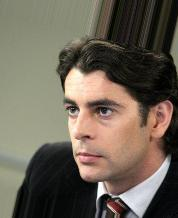

image size (218, 178, 3) 


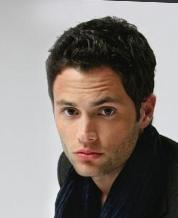

image size (218, 178, 3) 


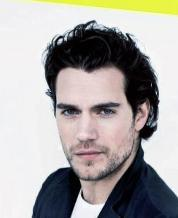

image size (218, 178, 3) 


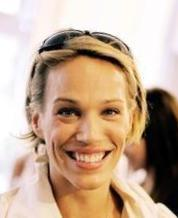

image size (218, 178, 3) 


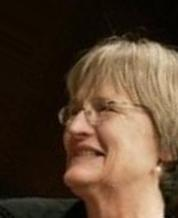

image size (218, 178, 3) 


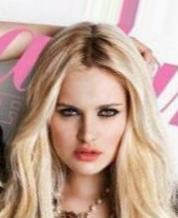

image size (218, 178, 3) 


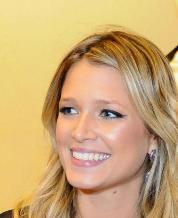

image size (218, 178, 3) 


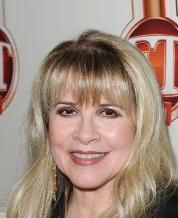

image size (218, 178, 3) 


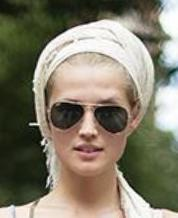

image size (218, 178, 3) 


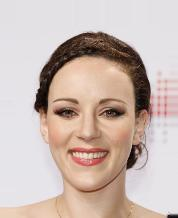

image size (218, 178, 3) 


In [234]:
for i in range(10):
  rndIndx=random.randint(0,len(clb_lst)-1)
  imgPath = os.path.join(main_path,clb_lst[rndIndx])
  img=cv2.imread(imgPath)
  cv2_imshow(img)
  print('image size {} '.format(img.shape))
   

##Creating Training Set

In [0]:
celeba_imgs_folder_path = os.path.join(celeba_path,'imgs/img_align_celeba')
clb_x= create_img_set(celeba_imgs_folder_path)

In [236]:
len(clb_x)

202599

Show randomly 25 images from the training set

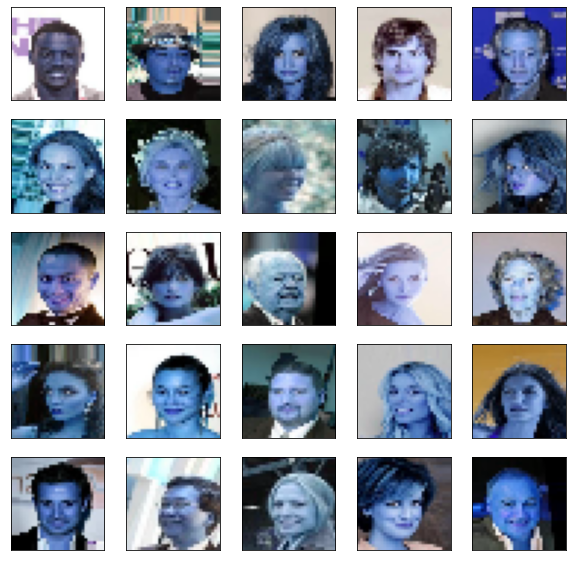

In [237]:
randomly_show_imgs(clb_x,5,5)

##Flatten the set

convert first the dsp_x from list to numpy array

In [0]:
clb_x_npa = np.array(clb_x)

In [304]:
clb_x_npa.shape

(202599, 32, 32, 3)

Convert the data from (202599, 32, 32, 3) to (202599, 3072) which is (202599, 32x32x3)

In [0]:
rows=int(clb_x_npa.shape[0])
cols=int(clb_x_npa.shape[1]*clb_x_npa.shape[2]*clb_x_npa.shape[3])
clb_x_npa=clb_x_npa.reshape(rows,cols)

In [306]:
clb_x_npa.shape

(202599, 3072)

###Plot the dataset

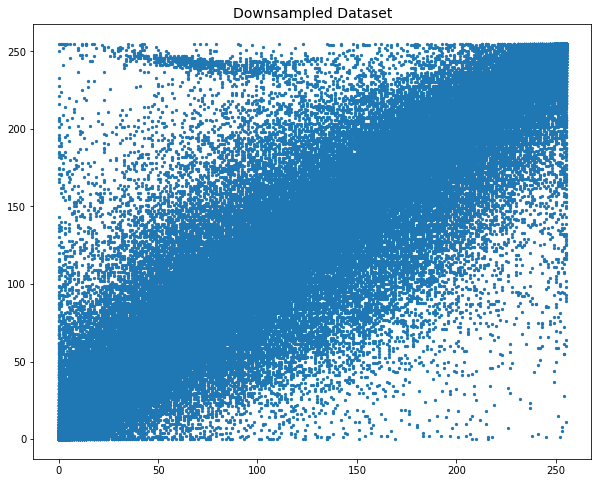

In [307]:
plt.figure(figsize=(10,8))
plt.scatter(clb_x_npa[:,0],clb_x_npa[:,1],s=5)
plt.title('Downsampled Dataset',fontsize =14)
plt.show()

###For sake of experiment speed, random subset size 10000 will be used.

In [0]:
clb_x_npa = clb_x_npa[10000:20000]
clb_x_npa.shape

### Apply PCA (Variation = 99%)

In [309]:
pca = PCA(0.99)
X_celeb_pca = pca.fit_transform(clb_x_npa)
pca.n_components_

894

##K-means clustering

Choose random numbers of $k$ to find the best one

In [310]:
k_range = range(2,10,1)
kmeans_per_k = []
for k in k_range:
    print("k={}".format(k))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_celeb_pca)
    kmeans_per_k.append(kmeans)

k=2
k=3
k=4
k=5
k=6
k=7
k=8
k=9


### Plot the silhouette score vs performance of $k$

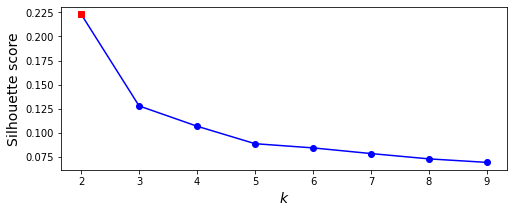

In [311]:
silhouette_scores = [silhouette_score(X_celeb_pca, model.labels_) for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, "rs")
plt.show()

###$k$ = 2 return the highest Sihouette score

In [312]:
best_k

2

##Plot K-Elbow

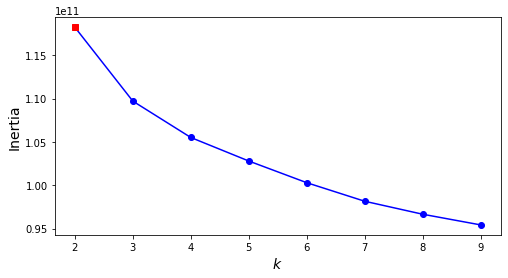

In [313]:
inertias = [model.inertia_ for model in kmeans_per_k]
best_inertia = inertias[best_index]

plt.figure(figsize=(8, 4))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.plot(best_k, best_inertia, "rs")
plt.show()

The elbow point is $k$ = 2

###Fit and Predict

Let's train a K-Means clusterer on this dataset. It will try to find each blob's center and assign each instance to the closest blob:

In [0]:
kmodel = KMeans(n_clusters=best_k, random_state=42)

In [0]:
y_celeb = kmodel.fit_predict(X_celeb_pca)

In [327]:
y_celeb

array([1, 1, 0, ..., 1, 0, 0], dtype=int32)

In [328]:
y_celeb is kmodel.labels_

True

Therefore, y_pred is the label (0, 1) tha represents for each cluster.

##With RandomForest Classifier



###Spliting data for training and testing set in ratio 70%-30%

In [0]:
clb_x_train, clb_x_test, clb_y_train, clb_y_test = train_test_split(X_celeb_pca, y_celeb, test_size=0.3, shuffle = True, random_state=42)

In [330]:
clb_x_train.shape, clb_y_train.shape, clb_x_test.shape, clb_y_test.shape

((7000, 894), (7000,), (3000, 894), (3000,))


Create the model and fit with the training set

In [331]:
from sklearn.ensemble import RandomForestClassifier

RF_clb = RandomForestClassifier(random_state=42)
RF_clb.fit(clb_x_train, clb_y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Perform cross validation using subset size 500

In [332]:
cross_val_score(RF_clb, X_celeb_pca[:500], y_celeb[:500], cv=3, scoring='accuracy').mean()

0.9100233268402954

Test the model using testing set

In [333]:
RF_clb.score(clb_x_test, clb_y_test)

0.9946666666666667

See the predict score

In [337]:
y_pred = RF_clb.predict(X_celeb_pca)
y_pred

array([1, 1, 0, ..., 1, 0, 0], dtype=int32)

In [338]:
accuracy_score(y_celeb, y_pred)

0.9984

See the confustion matrix

In [339]:
labels= np.unique(kmodel.labels_)
labels

array([0, 1], dtype=int32)

Text(0.5, 1.0, 'Confusion Matrix')

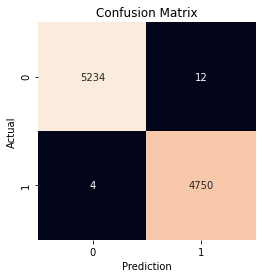

In [341]:
mat = confusion_matrix(y_pred, y_celeb)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Prediction')
plt.ylabel('Actual');
plt.title('Confusion Matrix')

See how RF classify the first 25 images

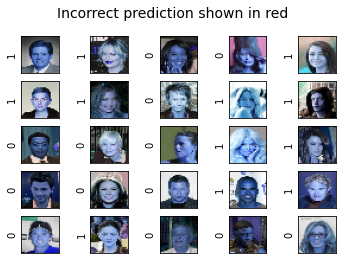

In [343]:
fig, ax = plt.subplots(5, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(clb_x[i])
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(str(labels[y_pred[i]]).split()[-1],
                   color='black' if y_pred[i] == y_celeb[i] else 'red')
fig.suptitle('Incorrect prediction shown in red', size=14);


There's no red number popup, that mean 100% rate prediction for first 25 images.

##Use K-Means as a dimensionality reduction tool and train a classifier on the reduced set


In [0]:
best_model = kmeans_per_k[best_index]
X_train_reduced = best_model.transform(clb_x_train)
X_test_reduced = best_model.transform(clb_x_test)

In [346]:
X_train_reduced.shape,X_test_reduced.shape

((7000, 2), (3000, 2))

Perform cross validation using subset size 500

In [347]:
cross_val_score(RF_clb, X_train_reduced[:500], clb_y_train[:500], cv=3, scoring='accuracy').mean()

0.9760358800471346


Fit to training model

In [348]:
RF_clb.fit(X_train_reduced, clb_y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Test the model using testing set

In [349]:
RF_clb.score(X_test_reduced, clb_y_test)

0.9943333333333333

The accuracy is slighly lower than using PCA.

##Search for the number of clusters that provides the best performance.

In [355]:
from sklearn.pipeline import Pipeline
#This list to be used for visualization
pipe_clb_scores = []
for n_clusters in range(1,10):
    pipe_clb = Pipeline([
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=42)),
        ("forest_clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    
    pipe_clb.fit(clb_x_train, clb_y_train)

    pipe_clb_scores.append([])
    pipe_clb_scores[n_clusters-1].append(n_clusters)
    score = pipe_clb.score(clb_x_test, clb_y_test)
    pipe_clb_scores[n_clusters-1].append(score)
    
    print(n_clusters, score)

1 0.5633333333333334
2 0.994
3 0.9943333333333333
4 0.9946666666666667
5 0.9933333333333333
6 0.9946666666666667
7 0.9953333333333333
8 0.9946666666666667
9 0.9936666666666667


So n_clusters >= 2 provides similar high performance.

##With Gaussian Mixtures

Train a Gaussian mixture model on the training set

In [350]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=best_k, n_init=10, random_state=42)
gm.fit(clb_x_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

Did the algorithm actually converge?

In [351]:
gm.converged_

True

Yes, good. How many iterations did it take?

In [352]:
gm.n_iter_

12

You can now use the model to predict which cluster each instance belongs to (hard clustering) or the probabilities that it came from each cluster.

In [353]:
gm.predict(clb_x_test)

array([1, 0, 1, ..., 1, 1, 0])

##Anomaly Detection using Gaussian Mixtures

Gaussian Mixtures can be used for anomaly detection: instances located in low-density regions can be considered anomalies. You must define what density threshold you want to use. For example, in a manufacturing company that tries to detect defective products, the ratio of defective products is usually well-known. Say it is equal to 4%, then you can set the density threshold to be the value that results in having 4% of the instances located in areas below that threshold density:

In [0]:
densities = gm.score_samples(clb_x_blob)
density_threshold = np.percentile(densities, 4)
anomalies = clb_x_blob[densities < density_threshold]

In [0]:
plt.figure(figsize=(10, 10))

plot_gaussian_mixture(gm, clb_x_blob)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)
plt.show()

#Downsampled Dataset

In [356]:
url = 'http://image-net.org/small/train_32x32.tar'
save_path = downsampled_path
download(url,save_path=save_path)

file is being downloading from http://image-net.org/small/train_32x32.tar ...
Done, file in the path data/downsampled/train_32x32.tar


Extract the train_32x32 dataset to the path data/downsampled/imgs/

In [357]:
extractTar(os.path.join(downsampled_path,'train_32x32.tar'),os.path.join(downsampled_path,'imgs'))

Extracting is starting....
Done


##Exploring Data 

list randomly 10 images of the training data

In [358]:
main_path = os.path.join(downsampled_path,'imgs/train_32x32/')

dsp_lst=os.listdir(main_path)
len(dsp_lst)

1281149

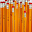

image size (32, 32, 3) 


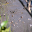

image size (32, 32, 3) 


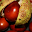

image size (32, 32, 3) 


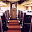

image size (32, 32, 3) 


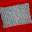

image size (32, 32, 3) 


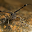

image size (32, 32, 3) 


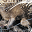

image size (32, 32, 3) 


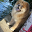

image size (32, 32, 3) 


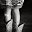

image size (32, 32, 3) 


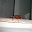

image size (32, 32, 3) 


In [359]:
for i in range(10):
  rndIndx=random.randint(0,len(dsp_lst)-1)
  imgPath = os.path.join(main_path,dsp_lst[rndIndx])
  img=cv2.imread(imgPath)
  cv2_imshow(img)
  print('image size {} '.format(img.shape))
   

##Creating Training Set

In [0]:
downsampled_imgs_folder_path = os.path.join(downsampled_path,'imgs/train_32x32')
dsp_x= create_img_set(downsampled_imgs_folder_path)

In [361]:
len(dsp_x)

1281149

Show randomly 25 images from the training set

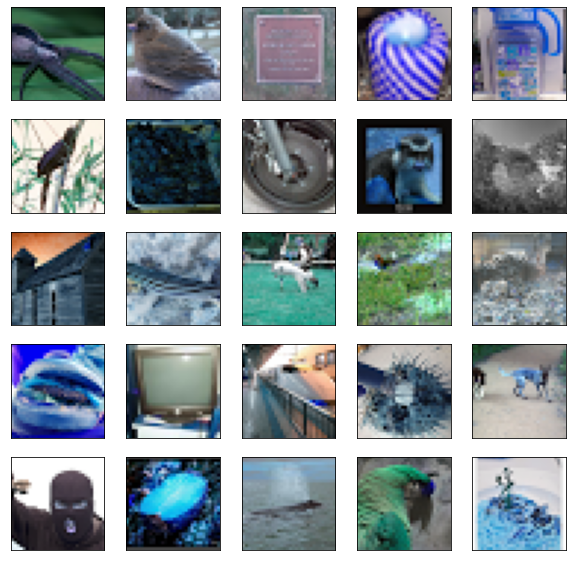

In [362]:
randomly_show_imgs(dsp_x,5,5)

##Flatten the set

convert first the dsp_x from list to numpy array

In [0]:
dsp_x_npa = np.array(dsp_x)

In [364]:
dsp_x_npa.shape

(1281149, 32, 32, 3)

Convert the data from (1281149, 32, 32, 3) to (1281149, 3072) which is (1281149, 32x32x3)

In [0]:
rows=int(dsp_x_npa.shape[0])
cols=int(dsp_x_npa.shape[1]*dsp_x_npa.shape[2]*dsp_x_npa.shape[3])
dsp_x_npa=dsp_x_npa.reshape(rows,cols)

In [366]:
dsp_x_npa.shape

(1281149, 3072)

###Plot the dataset

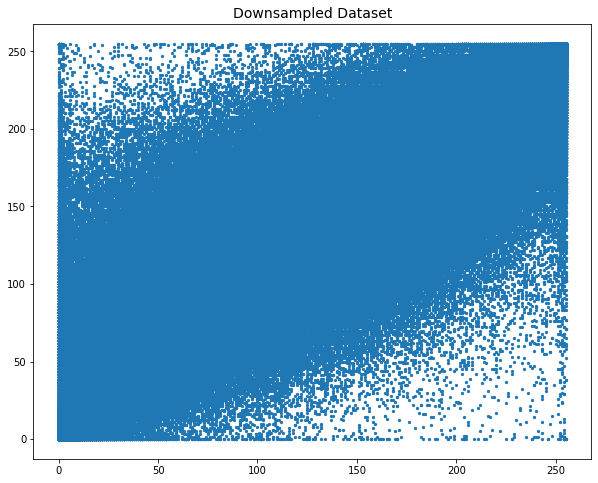

In [368]:
plt.figure(figsize=(10,8))
plt.scatter(dsp_x_npa[:,0],dsp_x_npa[:,1],s=5)
plt.title('Downsampled Dataset',fontsize =14)
plt.show()

###For sake of experiment speed, random subset size 10000 will be used.

In [369]:
dsp_x_npa = dsp_x_npa[:10000]
dsp_x_npa.shape

(10000, 3072)

### Apply PCA (Variation = 99%)

In [370]:
pca = PCA(0.99)
X_dsp_pca = pca.fit_transform(dsp_x_npa)
pca.n_components_

1123

##K-means clustering

Choose random numbers of $k$ to find the best one

In [371]:
k_range = range(2,10,1)
kmeans_per_k = []
for k in k_range:
    print("k={}".format(k))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_dsp_pca)
    kmeans_per_k.append(kmeans)

k=2
k=3
k=4
k=5
k=6
k=7
k=8
k=9


### Plot the silhouette score vs performance of $k$

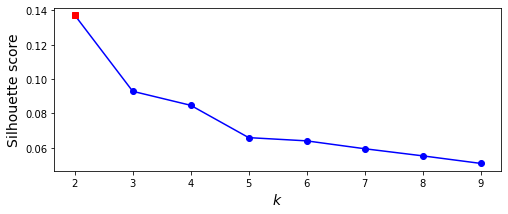

In [372]:
silhouette_scores = [silhouette_score(X_dsp_pca, model.labels_) for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, "rs")
plt.show()

###$k$ = 2 return the highest Sihouette score

In [373]:
best_k

2

##Plot K-Elbow

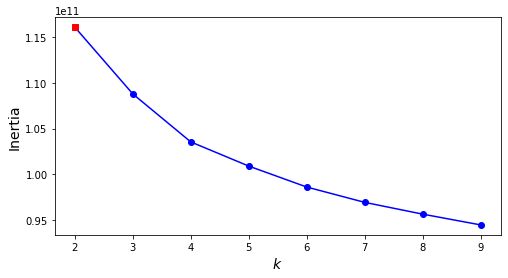

In [374]:
inertias = [model.inertia_ for model in kmeans_per_k]
best_inertia = inertias[best_index]

plt.figure(figsize=(8, 4))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.plot(best_k, best_inertia, "rs")
plt.show()

The elbow point is $k$ = 2

###Fit and Predict

Let's train a K-Means clusterer on this dataset. It will try to find each blob's center and assign each instance to the closest blob:

In [0]:
kmodel = KMeans(n_clusters=best_k, random_state=42)

In [0]:
y_dsp = kmodel.fit_predict(X_dsp_pca)

In [377]:
y_dsp

array([1, 0, 1, ..., 0, 0, 1], dtype=int32)

In [378]:
np.unique(y_dsp)

array([0, 1], dtype=int32)

In [386]:
y_dsp is kmodel.labels_

True

Therefore, y_dsp is the label (0, 1) tha represents for each cluster.


##With RandomForest Classifier



###Spliting data for training and testing set in ratio 70%-30%

In [0]:
dsp_x_train, dsp_x_test, dsp_y_train, dsp_y_test = train_test_split(X_dsp_pca, y_dsp, test_size=0.3, shuffle = True, random_state=42)

In [381]:
dsp_x_train.shape, dsp_y_train.shape, dsp_x_test.shape, dsp_y_test.shape

((7000, 1123), (7000,), (3000, 1123), (3000,))


Create the model and fit with the training set

In [382]:
from sklearn.ensemble import RandomForestClassifier

RF_dsp = RandomForestClassifier(random_state=42)
RF_dsp.fit(dsp_x_train, dsp_y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Perform cross validation using subset size 500

In [387]:
cross_val_score(RF_dsp, X_dsp_pca[:500], y_dsp[:500], cv=3, scoring='accuracy').mean()

0.850010821730034

Test the model using testing set

In [388]:
RF_dsp.score(dsp_x_test, dsp_y_test)

0.9836666666666667

See the predict score

In [389]:
y_pred = RF_dsp.predict(X_dsp_pca)
y_pred

array([1, 0, 1, ..., 0, 0, 1], dtype=int32)

In [390]:
accuracy_score(y_dsp, y_pred)

0.9951

See the confustion matrix

In [391]:
labels= np.unique(kmodel.labels_)
labels

array([0, 1], dtype=int32)

Text(0.5, 1.0, 'Confusion Matrix')

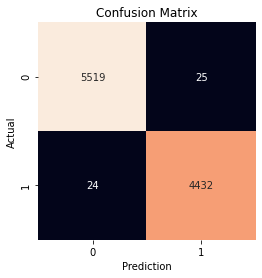

In [392]:
mat = confusion_matrix(y_pred, y_dsp)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Prediction')
plt.ylabel('Actual');
plt.title('Confusion Matrix')

See how RF classify the first 25 images

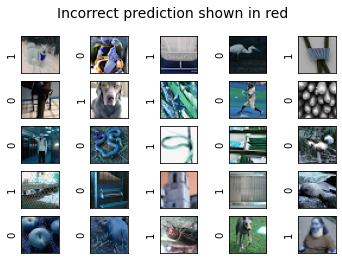

In [393]:
fig, ax = plt.subplots(5, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(dsp_x[i])
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(str(labels[y_pred[i]]).split()[-1],
                   color='black' if y_pred[i] == y_dsp[i] else 'red')
fig.suptitle('Incorrect prediction shown in red', size=14);


There's no red number popup, that mean 100% rate prediction for the first 25 images.

##Use K-Means as a dimensionality reduction tool and train a classifier on the reduced set


In [0]:
best_model = kmeans_per_k[best_index]
X_train_reduced = best_model.transform(dsp_x_train)
X_test_reduced = best_model.transform(dsp_x_test)

In [396]:
X_train_reduced.shape,X_test_reduced.shape

((7000, 2), (3000, 2))

Perform cross validation using subset size 500

In [397]:
cross_val_score(RF_dsp, X_train_reduced[:500], dsp_y_train[:500], cv=3, scoring='accuracy').mean()

0.9660317918380107


Fit to training model

In [398]:
RF_dsp.fit(X_train_reduced, dsp_y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Test the model using testing set

In [399]:
RF_dsp.score(X_test_reduced, dsp_y_test)

0.992

The accuracy is same as PCA.

##Search for the number of clusters that provides the best performance.

In [400]:
from sklearn.pipeline import Pipeline
#This list to be used for visualization
pipe_dsp_scores = []
for n_clusters in range(1,10):
    pipe_dsp = Pipeline([
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=42)),
        ("forest_clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    
    pipe_dsp.fit(dsp_x_train, dsp_y_train)

    pipe_dsp_scores.append([])
    pipe_dsp_scores[n_clusters-1].append(n_clusters)
    score = pipe_dsp.score(dsp_x_test, dsp_y_test)
    pipe_dsp_scores[n_clusters-1].append(score)
    
    print(n_clusters, score)

1 0.5283333333333333
2 0.9913333333333333
3 0.9893333333333333
4 0.9896666666666667
5 0.9906666666666667
6 0.9876666666666667
7 0.989
8 0.9906666666666667
9 0.991


So n_clusters >= 2 provides similar high accuracy for the classifier.

##With Gaussian Mixtures

Train a Gaussian mixture model on the training set

In [401]:

from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=best_k, n_init=10, random_state=42)
gm.fit(dsp_x_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

Did the algorithm actually converge?

In [402]:
gm.converged_

True

Yes, good. How many iterations did it take?

In [403]:
gm.n_iter_

24

You can now use the model to predict which cluster each instance belongs to (hard clustering) or the probabilities that it came from each cluster.


In [405]:
gm.predict(dsp_x_test)

array([0, 0, 0, ..., 0, 1, 1])


Now let's plot the resulting decision boundaries (dashed lines) and density contours:

In [0]:
plt.figure(figsize=(10, 10))
plot_gaussian_mixture(gm, dsp_x_blob)
plt.show()

##Anomaly Detection using Gaussian Mixtures

Gaussian Mixtures can be used for anomaly detection: instances located in low-density regions can be considered anomalies. You must define what density threshold you want to use. For example, in a manufacturing company that tries to detect defective products, the ratio of defective products is usually well-known. Say it is equal to 4%, then you can set the density threshold to be the value that results in having 4% of the instances located in areas below that threshold density:

In [0]:
densities = gm.score_samples(dsp_x_blob)
density_threshold = np.percentile(densities, 4)
anomalies = dsp_x_blob[densities < density_threshold]

In [0]:
plt.figure(figsize=(10,10))

plot_gaussian_mixture(gm, dsp_x_blob)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)
plt.show()

# Summary


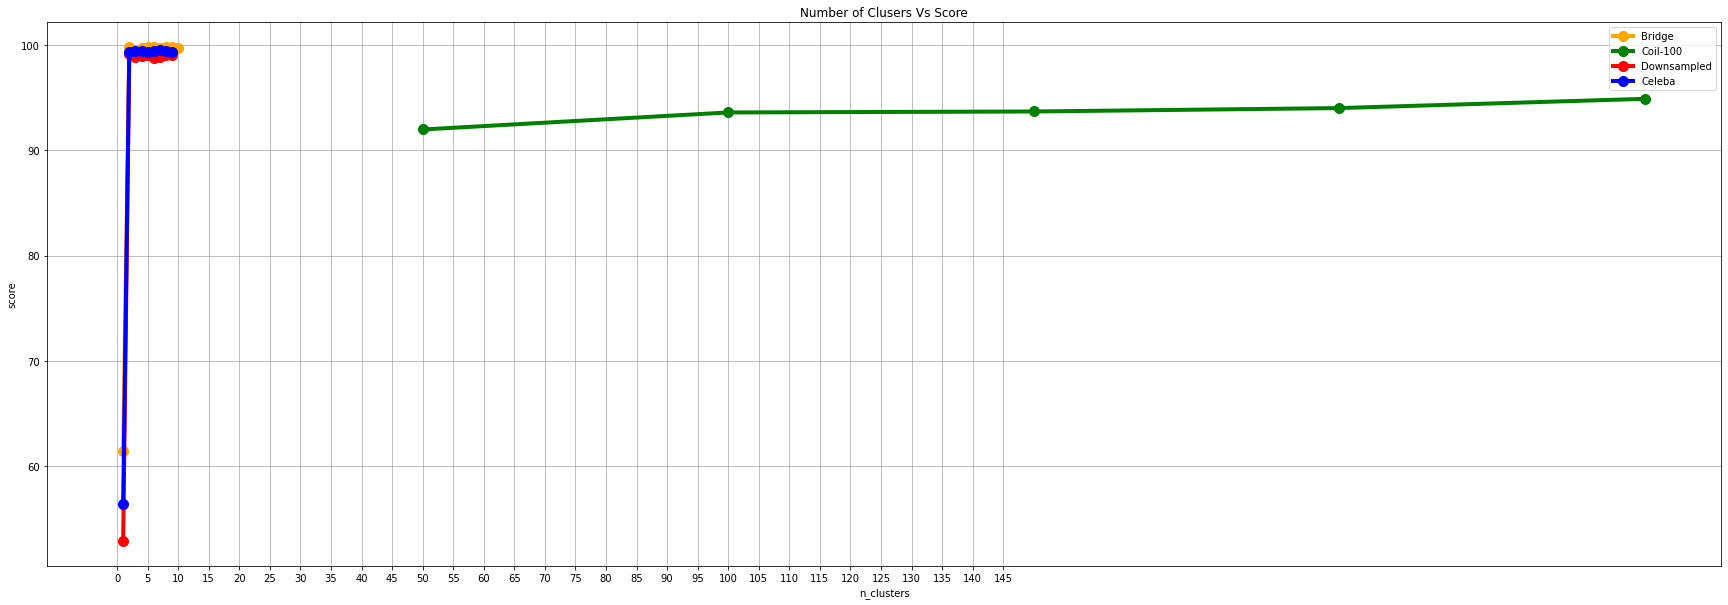

In [404]:
#Convert the list to a DataFrame to get each column separately
pipe_bridge_scores_df = pd.DataFrame(pipe_bridge_scores,columns=['n_cluster','score'])
pipe_bridge_n_clusters = pipe_bridge_scores_df['n_cluster']
pipe_bridge_scores_only = pipe_bridge_scores_df['score']

pipe_coil100_scores_df = pd.DataFrame(pipe_coil100_scores,columns=['n_cluster','score'])
pipe_coil100_n_clusters = pipe_coil100_scores_df['n_cluster']
pipe_coil100_scores_only = pipe_coil100_scores_df['score']

pipe_dsp_scores_df = pd.DataFrame(pipe_dsp_scores,columns=['n_cluster','score'])
pipe_dsp_n_clusters = pipe_dsp_scores_df['n_cluster']
pipe_dsp_scores_only = pipe_dsp_scores_df['score']

pipe_clb_scores_df = pd.DataFrame(pipe_clb_scores,columns=['n_cluster','score'])
pipe_clb_n_clusters = pipe_clb_scores_df['n_cluster']
pipe_clb_scores_only = pipe_clb_scores_df['score']

#Plot the chart
linewidth= 4.0
markersize=10.0
plt.figure(figsize=(30,10))
plt.plot(pipe_bridge_n_clusters,pipe_bridge_scores_only*100,'bo-',label='Bridge',color='orange',linewidth=linewidth, markersize=markersize)
plt.plot(pipe_coil100_n_clusters,pipe_coil100_scores_only*100,'bo-',label='Coil-100',color='green',linewidth=linewidth, markersize=markersize)
plt.plot(pipe_dsp_n_clusters,pipe_dsp_scores_only*100,'bo-',label='Downsampled',color='red',linewidth=linewidth, markersize=markersize)
plt.plot(pipe_clb_n_clusters,pipe_clb_scores_only*100,'bo-',label='Celeba',color='blue',linewidth=linewidth, markersize=markersize)
plt.xlabel('n_clusters')
plt.ylabel('score')
plt.title('Number of Clusers Vs Score')
plt.xticks(range(0,150,5))
plt.legend()
plt.grid(True)
plt.show()